# Operations on VertexFunctions

In [1]:
%matplotlib ipympl
import matplotlib.pyplot as plt
import numpy as np
import sys, os
sys.path.append(os.path.relpath("../../src"))
import hiped as hp

## 1) Scalar case
Elementary VertexFunctions can be combined with others, the computation of the expression and derivative is done automatically.
### a) Some operations

In [2]:
f1s = hp.VertexFunction("f1s", lambda u: u**2, lambda u: 2*u)
f2s = hp.VertexFunction("f2s", lambda u: u**3, lambda u: 3*u**2)
f3s = hp.VertexFunction("f3s", lambda u: 0.1*u, lambda u: 0.1*np.ones(u.shape))

- *Operations with scalars*

In [3]:
f4s = 2*f1s + 3
print(f4s)

2 * f1s + 3


- *Operations with other* ``VertexFunctions``

In [4]:
f5s = f1s*(f2s/3+f3s*2)**(-f2s)
print(f5s)
f6s = f1s/f3s
print(f6s)

f1s * (f2s / 3 + f3s * 2) ** (-f2s)
f1s / f3s


### b) Interpolation
#### i) Definition of the interpolation domain

In [5]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

P = [1]
def f(x,y,z, P):
    plt.clf()
    P[0] = hp.Penalization(x, y, z)
    P[0].plot()
    plt.show()

plt.figure()
p = widgets.FloatSlider(min=0., max=5., step=0.1, value=2.)
type = ["SIMP", "RAMP", "Lukas", "Zhou"]
reversed = widgets.Checkbox(value=False)
interact(lambda type,p, reversed : f(type, p, reversed, P), type=type, p = p, reversed =reversed )

interpScalar= hp.Interpolation(domain = hp.Domain(6), children = [f1s,f2s,f3s,f4s,f5s,f6s],
                               label = "interpScalar", penalization = P[0])

interactive(children=(Dropdown(description='type', options=('SIMP', 'RAMP', 'Lukas', 'Zhou'), value='SIMP'), F…

#### ii) Coordinates in the polygon $x$ and scalar field $u$
Then the $n$ cartesian coordinates $x$ and the scalar field $u$ should be defined to evaluate the interpolation.

In [6]:
x0, u0 = [0], [0]

def f(n, typeInit, r, u, x):
    plt.clf()
    x0[0] = interpScalar.setInitialVariable(n, typeInit = typeInit, radius = r) # initialization of the variables
    x0[0] = interpScalar.projection(x0[0]) # projection onto the domain
    interpScalar.plot(x0[0])
    u0[0] = np.random.rand(1,1,n)
    plt.show()

n = widgets.IntSlider(min=1, max=1000, step=1, value=500)
typeInit = ["rand","zero"]
r = widgets.FloatSlider(min=0, max=2, step=0.1, value=1)
plt.figure()
_ = interact(lambda n, typeInit, r : f(n, typeInit, r, u0, x0), n=n, typeInit = typeInit, r =r )   
x, u = x0[0], u0[0]

interactive(children=(IntSlider(value=500, description='n', max=1000, min=1), Dropdown(description='typeInit',…

### c) Evaluation

In [7]:
import time
t0 = time.time()
w, dwdx = interpScalar.evalBasisFunction(x)
tv0 = time.time() - t0
print(f"Compute basis functions in {tv0*1000:.3f} ms")

t0 = time.time()
f = interpScalar.eval(x, u, w) # value
tv1 = time.time() - t0
print(f"Compute interpolated values in {tv1*1000:.3f} ms")

t0 = time.time()
dfdu =  interpScalar.evaldu(x, u, w) # derivative w.r.t a
tv2 = time.time() - t0
print(f"Compute interpolated u-derivative in {tv2*1000:.3f} ms")

t0 = time.time()
dfdx =  interpScalar.evaldx(x, u, w, dwdx) # derivative w.r.t x
tv3 = time.time() - t0
print(f"Compute interpolated x-derivative in {tv3*1000:.3f} ms")

Compute basis functions in 0.685 ms
Compute interpolated values in 0.000 ms
Compute interpolated u-derivative in 0.000 ms
Compute interpolated x-derivative in 0.000 ms


#### Check Taylor expansions

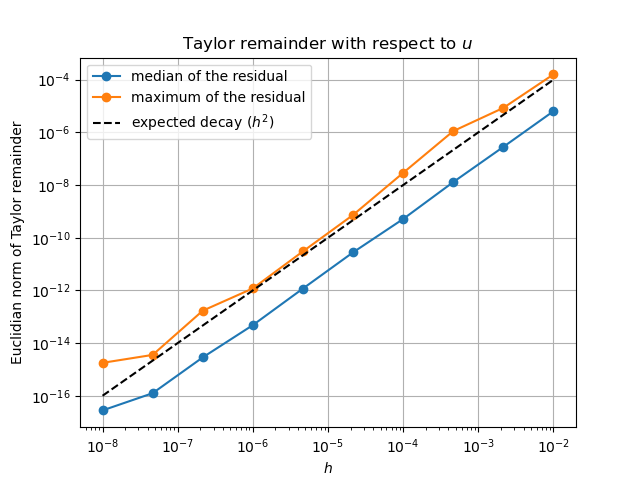

In [8]:
from hiped.utils import mult

# derivative with respect to u
h = np.logspace(-8,-2,10) # test for 10 different h
resU = np.zeros((10,1,u.shape[2]))


for i in range(10):
    pert = h[i]*np.random.rand(*u.shape)
    fPerturbedu = interpScalar.eval(x,u+pert)
    resU[i,0,:] = np.linalg.norm(fPerturbedu - (f + mult(dfdu,pert)), axis = 0)
    
maxResU = np.max(resU, axis = 2); medResU = np.median(resU, axis = 2);

plt.figure()
plt.loglog(h, medResU,'-o', label =  "median of the residual")
plt.loglog(h, maxResU,'-o', label =  "maximum of the residual")
plt.loglog(h, h**2,'k--', label =  "expected decay $(h^2)$")

plt.legend(loc = "best"); plt.grid()
plt.xlabel("$h$"); plt.ylabel("Euclidian norm of Taylor remainder")
plt.title("Taylor remainder with respect to $u$")

plt.show()

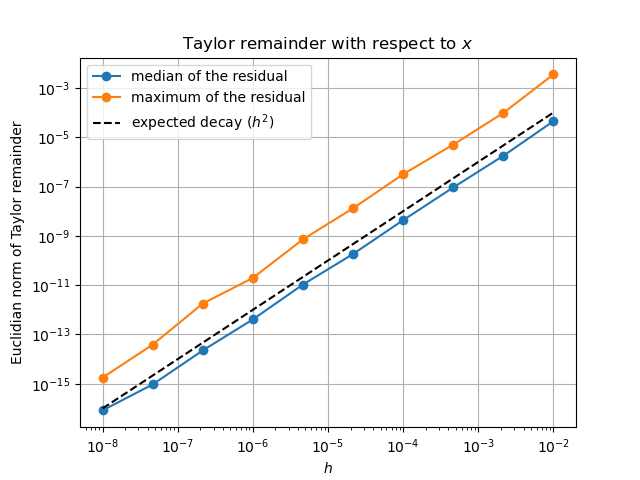

In [9]:
# derivative with respect to x

resX = np.zeros((10,1,u.shape[2]))
l = list(x.keys())[0]
xPert = x.copy()

for i in range(10):
    pert = h[i]*np.random.rand(*x[l].shape)
    xPert[l] = x[l] + pert
    fPerturbedx = interpScalar.eval(xPert,u)
    pert = np.reshape(pert.T, (2,1,-1))
    resX[i,0,:] = np.linalg.norm(fPerturbedx - (f + mult(dfdx[l],pert)), axis = 0)

maxResX = np.max(resX, axis = 2); medResX = np.median(resX, axis = 2);

plt.figure()
plt.loglog(h, medResX,'-o', label =  "median of the residual")
plt.loglog(h, maxResX,'-o', label =  "maximum of the residual")
plt.loglog(h, h**2,'k--', label =  "expected decay $(h^2)$")

plt.legend(loc = "best"); plt.grid()
plt.xlabel("$h$"); plt.ylabel("Euclidian norm of Taylor remainder")
plt.title("Taylor remainder with respect to $x$")

plt.show()

## 2) Vector case
### a) Some operations

In [10]:
from hiped.utils import mult

dimInput = 2
dimOutput = 2

f1v = hp.VertexFunction(label = "f1v", f = lambda u : u**2, dfdu = lambda u : 2*u * np.eye(2)[:,:,None], dimInput= dimInput, dimOutput = dimOutput)
f2v = hp.VertexFunction("f2v", lambda u : mult(np.array([[1,2],[3,4]]), u), lambda u : np.array([[1,2],[3,4]])[:,:,None] * np.ones(u.shape), dimInput, dimOutput)
f3v = hp.VertexFunction("f3v", lambda u : 0.1*u, lambda u : 0.1 * np.eye(2)[:,:,None] * np.ones(u.shape), dimInput, dimOutput)

fMat =  hp.VertexFunction("fMat", lambda u : np.array([[1,2],[3,4]]).reshape(2,2,1)*np.ones(u.shape), lambda u : np.zeros(u.shape) * np.zeros((2,2,1)), dimInput, (2,2))
fConst =  hp.VertexFunction("fConst", lambda u : np.ones((1,1,1))*np.ones(u.shape), lambda u : np.zeros((1,1,1))*np.zeros(u.shape), dimInput, 1)
fConst2 =  hp.VertexFunction("fConst2", lambda u : np.ones((2,1,1))*np.ones(u.shape), lambda u : np.zeros((2,2,1))*np.zeros(u.shape), dimInput, 2)

f4v = fMat @ f1v * (f3v+f2v) / 2 # only multiplication by constant matrix is supported
print(f4v)
f5v = 3* f1v.innerProduct(f2v+f3v)**f1v 
print(f5v)

fMat @ f1v * (f3v + f2v) / 2
3 * (<f1v , (f2v + f3v)>) ** f1v


### b) Interpolation
#### i) Definition of the interpolation domain

In [11]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

P = [1]
def f(x,y,z, P):
    plt.clf()
    P[0] = hp.Penalization(x, y, z)
    P[0].plot()
    plt.show()

plt.figure()
p = widgets.FloatSlider(min=0., max=5., step=0.1, value=2.)
type = ["SIMP", "RAMP", "Lukas", "Zhou"]
reversed = widgets.Checkbox(value=False)
interact(lambda type,p, reversed : f(type, p, reversed, P), type=type, p = p, reversed =reversed )

interpVector= hp.Interpolation(domain = hp.Domain(5), children = [f1v,f2v,f3v,f4v,f5v],
                               label = "interpVector", penalization = P[0])

interactive(children=(Dropdown(description='type', options=('SIMP', 'RAMP', 'Lukas', 'Zhou'), value='SIMP'), F…

#### ii) Coordinates in the polygon $x$ and scalar field $u$
Then the $n$ cartesian coordinates $x$ and the scalar field $u$ should be defined to evaluate the interpolation.

In [12]:
xv0, uv0 = [0], [0]

def f(n, typeInit, r, u, x):
    plt.clf()
    xv0[0] = interpVector.setInitialVariable(n, typeInit = typeInit, radius = r) # initialization of the variables
    xv0[0] = interpVector.projection(xv0[0]) # projection onto the domain
    interpVector.plot(xv0[0])
    uv0[0] = np.random.rand(dimInput,1,n)
    plt.show()

n = widgets.IntSlider(min=1, max=1000, step=1, value=500)
typeInit = ["rand","zero"]
r = widgets.FloatSlider(min=0, max=2, step=0.1, value=1)
plt.figure()
_ = interact(lambda n, typeInit, r : f(n, typeInit, r, uv0, xv0), n=n, typeInit = typeInit, r =r )   
x, u = xv0[0], uv0[0]

interactive(children=(IntSlider(value=500, description='n', max=1000, min=1), Dropdown(description='typeInit',…

### c) Evaluation

In [13]:
import time
t0 = time.time()
w, dwdx = interpVector.evalBasisFunction(x)
tv0 = time.time() - t0
print(f"Compute basis functions in {tv0*1000:.3f} ms")

t0 = time.time()
f = interpVector.eval(x, u, w) # value
tv1 = time.time() - t0
print(f"Compute interpolated values in {tv1*1000:.3f} ms")

t0 = time.time()
dfdu =  interpVector.evaldu(x, u, w) # derivative w.r.t a
tv2 = time.time() - t0
print(f"Compute interpolated u-derivative in {tv2*1000:.3f} ms")

t0 = time.time()
dfdx =  interpVector.evaldx(x, u, w, dwdx) # derivative w.r.t x
tv3 = time.time() - t0
print(f"Compute interpolated x-derivative in {tv3*1000:.3f} ms")

Compute basis functions in 0.000 ms
Compute interpolated values in 8.486 ms
Compute interpolated u-derivative in 3.020 ms
Compute interpolated x-derivative in 0.000 ms


#### Check the Taylor expansion

We introduce small perturbations and check if the finite difference estimation of the derivative converges to the computed one.

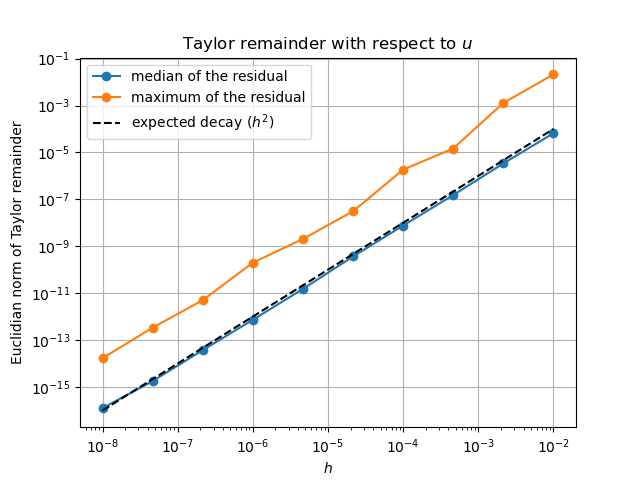

In [14]:
# derivative with respect to u
h = np.logspace(-8,-2,10) # test for 10 different h
resU = np.zeros((10,1,u.shape[2]))


for i in range(10):
    pert = h[i]*np.random.rand(*u.shape)
    fPerturbedu = interpVector.eval(x,u+pert)
    resU[i,0,:] = np.linalg.norm(fPerturbedu - (f + mult(dfdu,pert)), axis = 0)
    
maxResU = np.max(resU, axis = 2); medResU = np.median(resU, axis = 2);

plt.figure()
plt.loglog(h, medResU,'-o', label =  "median of the residual")
plt.loglog(h, maxResU,'-o', label =  "maximum of the residual")
plt.loglog(h, h**2,'k--', label =  "expected decay $(h^2)$")

plt.legend(loc = "best"); plt.grid()
plt.xlabel("$h$"); plt.ylabel("Euclidian norm of Taylor remainder")
plt.title("Taylor remainder with respect to $u$")

plt.show()

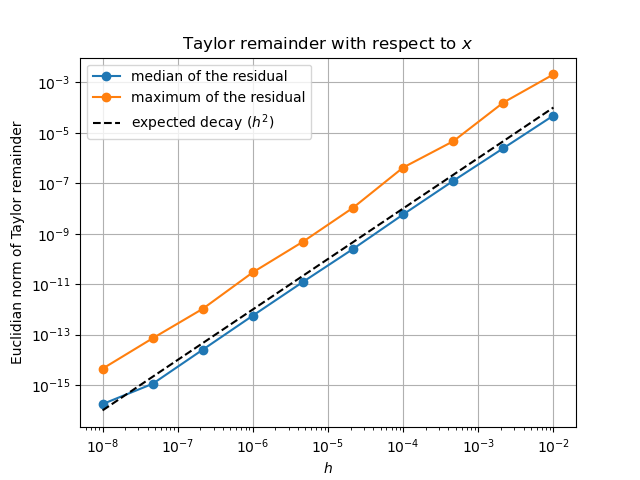

In [15]:
# derivative with respect to x

resX = np.zeros((10,1,u.shape[2]))
l = list(x.keys())[0]
xPert = x.copy()

for i in range(10):
    pert = h[i]*np.random.rand(*x[l].shape)
    xPert[l] = x[l] + pert
    fPerturbedx = interpVector.eval(xPert,u)
    pert = np.reshape(pert.T, (2,1,-1))
    resX[i,0,:] = np.linalg.norm(fPerturbedx - (f + mult(dfdx[l],pert)), axis = 0)

maxResX = np.max(resX, axis = 2); medResX = np.median(resX, axis = 2);

plt.figure()
plt.loglog(h, medResX,'-o', label =  "median of the residual")
plt.loglog(h, maxResX,'-o', label =  "maximum of the residual")
plt.loglog(h, h**2,'k--', label =  "expected decay $(h^2)$")

plt.legend(loc = "best"); plt.grid()
plt.xlabel("$h$"); plt.ylabel("Euclidian norm of Taylor remainder")
plt.title("Taylor remainder with respect to $x$")

plt.show()